## Imports

In [1]:
import numpy as np
import torch

## Configuration

In [2]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Model
    "model": "WideResNet-28-10-torchdistill",
    "num_classes": 10,
    # Dataset
    "image_size": 32,
    "pure_noise_mean": [0.4988, 0.5040, 0.4926],
    "pure_noise_std": [0.2498, 0.2480, 0.2718],
    "pure_noise_count": 1000,
    "checkpoint_url": "https://drive.google.com/uc?id=1ZEaevP97mXYdLU_Jv6S5sm2oR3TZZLeF",
})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [4]:
import gdown

url = CONFIG.checkpoint_url
checkpoint_filepath = "checkpoints/for_analysis.pt"
gdown.download(url, checkpoint_filepath, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZEaevP97mXYdLU_Jv6S5sm2oR3TZZLeF
To: /workspace/pure-noise/checkpoints/for_analysis.pt
100%|██████████| 292M/292M [00:03<00:00, 93.3MB/s] 


'checkpoints/for_analysis.pt'

## Set Random Seed

In [5]:
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Initialize Model

In [6]:
from initializers import initialize_model

net = initialize_model(
    model_name=CONFIG.model, 
    num_classes=CONFIG.num_classes, 
    enable_dar_bn=False,
    dropout_rate=0,
)
net = net.to(device)
net = net.eval()

In [7]:
from checkpointing import load_checkpoint

load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)

## Generate Pure Noise Images

In [8]:
from replace_with_pure_noise import sample_noise_images

noise_images = sample_noise_images(
    image_size=CONFIG.image_size,
    mean=CONFIG.pure_noise_mean,
    std=CONFIG.pure_noise_std, 
    count=CONFIG.pure_noise_count,
)
noise_images = noise_images.to(device)

## Generate Predictions

In [9]:
with torch.no_grad():
    noise_image_outputs = net(noise_images)
    _, predictions = torch.max(noise_image_outputs, 1)
    predictions_list = predictions.cpu().tolist()

In [10]:
from collections import Counter

predictions_counter = Counter(predictions_list)

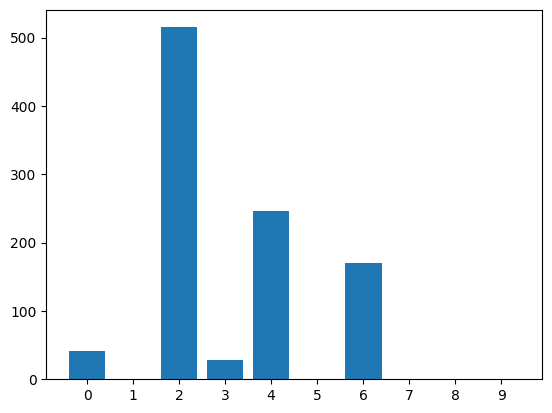

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(np.arange(CONFIG.num_classes), height=[predictions_counter[k] for k in np.arange(CONFIG.num_classes)])
ax.set_xticks(np.arange(CONFIG.num_classes))
fig.show()